WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, c, sigma]


/home/rob/miniconda3/envs/inps/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


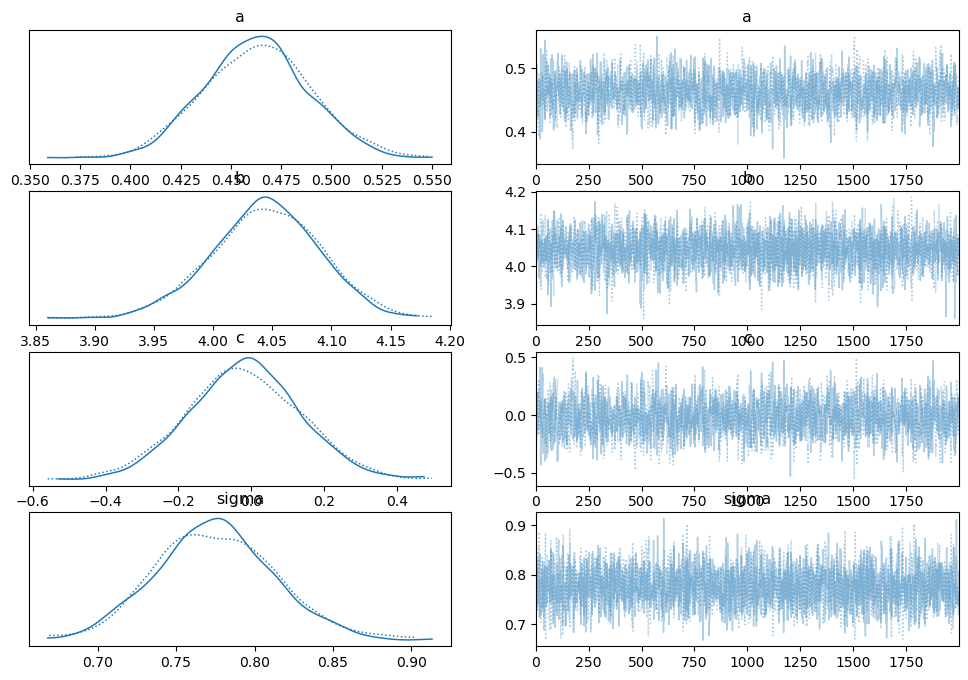

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      0.463  0.026   0.412    0.511      0.001    0.000    1833.0    2071.0   
b      4.044  0.046   3.957    4.130      0.001    0.001    2742.0    2331.0   
c     -0.019  0.153  -0.310    0.259      0.004    0.003    1803.0    1868.0   
sigma  0.775  0.038   0.704    0.846      0.001    0.000    3294.0    2602.0   

       r_hat  
a        1.0  
b        1.0  
c        1.0  
sigma    1.0  


In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Generate some synthetic data for demonstration
np.random.seed(0)
x = np.linspace(0, 10, 100)
true_a = 0.5
true_b = 2.0
true_c = -0.2
y = true_a * x + np.sin(true_b * x) + true_c + np.random.normal(0, 0.1, size=x.size)

# Define the Bayesian model
with pm.Model() as model:
    # Define priors for a, b, and c
    a = pm.Uniform("a", lower=-1, upper=1)
    b = pm.Uniform("b", lower=0, upper=6)
    c = pm.Uniform("c", lower=-1, upper=1)

    # Define the expected value of the model
    y_est = a * x + pm.math.sin(b * x) + c

    # Likelihood with observed data (assuming Gaussian noise with standard deviation 0.1)
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    y_obs = pm.Normal("y_obs", mu=y_est, sigma=sigma, observed=y)

    # Inference
    trace = pm.sample(2000, tune=1000, cores=2, target_accept=0.9)

# Plot the results
pm.plot_trace(trace)
plt.show()

# Summary of posterior distributions
print(pm.summary(trace))

In [2]:
class InformedBayesRegression:
    def __init__(self):
        self.trace = None
        self.summary = None
        self.model = None

    def fit(self, x_context, y_context, knowledge):
        # Convert torch tensors to NumPy arrays if necessary.
        if hasattr(x_context, "cpu"):
            x_context = x_context.cpu().detach().numpy()
        if hasattr(y_context, "cpu"):
            y_context = y_context.cpu().detach().numpy()
        if hasattr(knowledge, "cpu"):
            knowledge = knowledge.cpu().detach().numpy()

        with pm.Model() as model:
            # Define priors for a, b, and c
            a = pm.Uniform("a", lower=-1, upper=1)
            b = pm.Uniform("b", lower=0, upper=6)
            c = pm.Uniform("c", lower=-1, upper=1)

            # Optionally override priors with knowledge if available.
            # Use .item() to convert scalar arrays to Python floats.
            if knowledge[0, 0] == 1.0:
                a = (
                    knowledge[0, 3].item()
                    if hasattr(knowledge[0, 3], "item")
                    else knowledge[0, 3]
                )
            if knowledge[1, 1] == 1.0:
                b = (
                    knowledge[1, 3].item()
                    if hasattr(knowledge[1, 3], "item")
                    else knowledge[1, 3]
                )
            if knowledge[2, 2] == 1.0:
                c = (
                    knowledge[2, 3].item()
                    if hasattr(knowledge[2, 3], "item")
                    else knowledge[2, 3]
                )

            # Define the expected value of the model
            y_est = a * x_context + pm.math.sin(b * x_context) + c

            # Likelihood (assume Gaussian noise with standard deviation 0.1)
            sigma = pm.HalfNormal("sigma", sigma=0.1)
            y_obs = pm.Normal("y_obs", mu=y_est, sigma=sigma, observed=y_context)  # noqa: F841

            # Inference: sample from the posterior
            self.trace = pm.sample(2000, tune=1000, cores=2, target_accept=0.9)
            self.summary = pm.summary(self.trace)

        self.model = model

    def predict(self, x_target):
        # You might also need to convert x_target if it's a torch tensor:
        if hasattr(x_target, "cpu"):
            x_target = x_target.cpu().detach().numpy()

        a = self.summary["mean"]["a"]
        b = self.summary["mean"]["b"]
        c = self.summary["mean"]["c"]

        a_std = self.summary["sd"]["a"]
        b_std = self.summary["sd"]["b"]
        c_std = self.summary["sd"]["c"]

        y_mean = a * x_target + np.sin(b * x_target) + c
        y_upper = (a + a_std) * x_target + np.sin(b + b_std) * x_target + c + c_std
        y_lower = (a - a_std) * x_target + np.sin(b - b_std) * x_target + c - c_std

        return y_mean, y_upper, y_lower

In [3]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
from dataset.utils import get_dataloader
from dataset.dataset import SetKnowledgeTrendingSinusoids
from argparse import Namespace

# Setup the dataloaders
config = Namespace(
    min_num_context=0,
    max_num_context=100,
    num_targets=100,
    noise=0.2,
    batch_size=1,
    x_sampler="uniform",
    test_num_z_samples=32,
    dataset="set-trending-sinusoids",
    device="cuda:0",
)

dataset = SetKnowledgeTrendingSinusoids(
    root="../data/trending-sinusoids", split="test", knowledge_type="full"
)
data_loader = get_dataloader(dataset, config)

model = InformedBayesRegression()

for batch in data_loader:
    (x_context, y_context), (x_target, y_target), knowledge, extras = batch
    x_context, y_context, x_target, y_target = (
        x_context[0],
        y_context[0],
        x_target[0],
        y_target[0],
    )
    knowledge = knowledge[0]
    model.fit(x_context, y_context, knowledge)
    y_mean, y_upper, y_lower = model.predict(x_target)
    break

/home/rob/miniconda3/envs/inps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, c, sigma]


/home/rob/miniconda3/envs/inps/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [4]:
pm.summary(trace).loc["a", "mean"]

0.463